In [ ]:
import uuid
from typing import List, Optional, Literal, Dict, Any
import asyncio
import pandas as pd
import httpx
#from rapidfuzz import process
#from psycopg_pool import AsyncConnectionPool
import os
import hashlib
import time
import logging
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, CSVLoader
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, merge_message_runs
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
#from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph import StateGraph, START, END, MessagesState
#from langgraph.store.postgres.aio import AsyncPostgresStore
from langgraph.types import interrupt

from langchain_community.document_loaders import CSVLoader, WebBaseLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

from trustcall import create_extractor
# from model_loader import load_model
# from langchain_experimental.llms.ollama_functions import OllamaFunctions

from langchain_groq import ChatGroq


In [ ]:
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("API_KEY")

In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
model = ChatGroq(model="llama-3.3-70b-versatile", api_key=API_KEY)

In [ ]:
MSG_PROMPT= """
You are a whatsapp assistant, your duty is to assist business owners attend to customers.

Your primary responsibilities:
- Provide excellent customer service with a warm, conversational tone
- Help customers find information about menu items, pricing, and availability
- Remember customer preferences and delivery addresses for personalized service
- Guide customers through the complete order process including address collection
- Handle common questions efficiently while knowing when to escalate complex issues
- Add items to cart and always ask customer if they want to add to their order.
- When customers are ready to pay or complete their order, check for their address and confirm if they want pick-up or delivery.
- If user wants delivery, go through prior conversations to check for address, if no address provided during conversation, ask user for delivery address 

Customer Profile:
<user_profile>
{user_profile}
</user_profile>
"""

TRUSTCALL_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Past experiences
   - Goals or future plans
   - Delivery address
   - Ordered items
3. Merge any new information with existing memory
4. Format the memory as a clear, structured profile
5. If new information conflicts with existing memory, keep the most recent version

CRITICAL: 
- Use null (not the string "None") for fields with no information
- Only include factual information directly stated by the user
- Do not make assumptions or inferences
- Leave fields as null if not mentioned in the conversation

Based on the chat history below, please update the user information:"""

In [ ]:
class Profile(BaseModel):
    """User profile information for personalizing customer service.
    
    IMPORTANT: Use null for unknown fields, not the string "None".
    Only populate fields with actual information from the conversation.
    """
    
    name: Optional[str] = Field(
        default=None, 
        description="Customer's name. Use null if not mentioned."
    )
    location: Optional[str] = Field(
        default=None, 
        description="Customer's general location or city. Use null if not mentioned."
    )
    address: Optional[str] = Field(
        default=None, 
        description="Customer's full delivery address. Use null if not mentioned."
    )
    items: Optional[List[str]] = Field(
        default=None, 
        description="List of items in customer's order. Use null if no items ordered yet."
    )
    human_active: Optional[bool] = Field(
        default=None, 
        description="Whether a human agent is currently handling this customer. Use null if unknown."
    )

# -----------------------------
# Profile extractor
# -----------------------------
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)


# Update memory tool
class CustomerAction(BaseModel):
    """Handle customer requests which may include multiple actions.
    
    This tool should be called whenever the customer:
    - Shares personal information (name, address, preferences)
    - Asks about menu items or availability
    - Wants to place an order
    """
    
    update_profile: bool = Field(
        default=False,
        description="True if message contains profile information to save (name, location, address, preferences)"
    )
    
    search_menu: bool = Field(
        default=False,
        description="True if customer is asking about menu items, prices, or availability"
    )
    
    search_query: Optional[str] = Field(
        default=None,
        description="The specific menu item, category, or question they're asking about"
    )
    
    ready_to_order: bool = Field(
        default=False,
        description="True if customer is ready to place/finalize their order"
    )

    ready_to_pay: bool = Field(
        default=False,
        description="True if customer is ready to pay for their order"
    )

In [ ]:
def chatbot(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("profile", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MSG_PROMPT.format(user_profile=existing_memory_content)
    
    # FIXED: Pass both system message AND conversation history
    response = model.bind_tools([CustomerAction]).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )
    
    return {"messages": [response]}


# No extract_and_save_profile function at all!

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Extract and save profile information (all-in-one)."""
    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)
    
    existing_items = store.search(namespace)
    tool_name = "Profile"
    existing_memories = (
        [(item.key, tool_name, item.value) for item in existing_items]
        if existing_items else None
    )
    
    conversation_history = [
        msg for msg in state["messages"]
        if not (hasattr(msg, 'type') and msg.type == 'tool')
    ]
    
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(memory=existing_memories)
    updated_messages = list(merge_message_runs(
        [SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + conversation_history
    ))
    
    result = profile_extractor.invoke({
        "messages": updated_messages,
        "existing": existing_memories
    })
    
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )
    
    # Return LangGraph message directly (no helper function)
    tool_calls = state['messages'][-1].tool_calls
    
    return {
        "messages": [{
            "role": "tool",
            "content": "Profile information saved successfully",
            "tool_call_id": tool_calls[0]['id']
        }]
    }

In [ ]:
## RAG

# Setup logging
logger = logging.getLogger(__name__)

# Configuration
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# KB1 Setup
KB1_DOC_PATH = r"C:\Users\HP\Desktop\WAHA\synthetic_restaurant_menu_10000.csv"

# Module-level cache (outside functions)
_vector_store_cache = None
_retriever_cache = None
_file_hash_cache = None


def get_file_hash(path):
    """Compute a hash of the file contents to detect changes."""
    hasher = hashlib.sha256()
    with open(path, "rb") as f:
        hasher.update(f.read())
    return hasher.hexdigest()


def initialize_rag(doc_path=None):
    """Initialize RAG system with documents. Call once at startup."""
    global _vector_store_cache, _retriever_cache, _file_hash_cache
    
    # Check if already initialized
    if _vector_store_cache is not None:
        print("RAG already initialized")
        return _retriever_cache
    
    document_path = doc_path or KB1_DOC_PATH
    persist_dir = "./chroma_rag_KB1"

    try:
        _embeddings = HuggingFaceEmbeddings(
            model_name=EMBEDDING_MODEL_NAME,
            model_kwargs={'device': 'cpu'}
        )
        
        # Check if persisted DB exists
        if os.path.exists(persist_dir) and os.path.exists(document_path):
            current_hash = get_file_hash(document_path)
            
            # Try to load existing DB
            try:
                print("Loading existing knowledge base...")
                _vector_store_cache = Chroma(
                    collection_name="kb1_collection",  # Use fixed name
                    embedding_function=_embeddings,
                    persist_directory=persist_dir
                )
                _file_hash_cache = current_hash
                _retriever_cache = _vector_store_cache.as_retriever(search_kwargs={"k": 5})
                print("✅ Loaded existing knowledge base (fast load)")
                return _retriever_cache
            except Exception as e:
                print(f"Could not load existing DB: {e}. Rebuilding...")
        
        # If no existing DB or load failed, build from scratch
        print("Building knowledge base from scratch...")
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_documents = []
        
        # Load from document
        if document_path and os.path.exists(document_path):
            print(f"Processing {document_path}")
            if document_path.lower().endswith(".pdf"):
                loader = PyPDFLoader(document_path)
            elif document_path.lower().endswith(".docx"):
                loader = Docx2txtLoader(document_path)
            elif document_path.lower().endswith(".csv"):
                loader = CSVLoader(file_path=document_path, encoding="utf-8-sig")
            else:
                raise ValueError(f"Unsupported file format: {document_path}")
            
            docs = loader.load()
            doc_chunks = splitter.split_documents(docs)
            all_documents.extend(doc_chunks)
            print(f"Loaded {len(doc_chunks)} chunks from {document_path}")

        if not all_documents:
            raise ValueError("No documents were loaded")

        # Store file hash
        _file_hash_cache = get_file_hash(document_path)
        
        print(f"Creating knowledge base with {len(all_documents)} document chunks")
        _vector_store_cache = Chroma.from_documents(
            documents=all_documents,
            collection_name="kb1_collection", 
            embedding=_embeddings,
            persist_directory=persist_dir
        )
        
        _retriever_cache = _vector_store_cache.as_retriever(search_kwargs={"k": 5})
        print(f"✅ Setup complete")
        
        return _retriever_cache
      
    except Exception as e:
        logger.error(f"RAG initialization failed: {e}")
        raise

def refresh_rag(doc_path=None):
    """Refresh RAG when file changes detected."""
    global _vector_store_cache, _retriever_cache, _file_hash_cache
    
    print("🔄 Refreshing knowledge base...")
    
    # Clear cache
    _vector_store_cache = None
    _retriever_cache = None
    _file_hash_cache = None
    
    # Reinitialize
    retriever = initialize_rag(doc_path)
    print("✅ Knowledge base refreshed!")
    
    return retriever


# File change handler
class KBUpdateHandler(FileSystemEventHandler):
    def on_modified(self, event):
        if event.src_path == os.path.abspath(KB1_DOC_PATH):
            print(f"📁 Detected change in file: {event.src_path}")
            try:
                refresh_rag()
            except Exception as e:
                logger.error(f"Error refreshing: {e}")


def start_file_monitoring():
    """Start watching file for changes."""
    event_handler = KBUpdateHandler()
    observer = Observer()
    
    kb_dir = os.path.dirname(os.path.abspath(KB1_DOC_PATH))
    observer.schedule(event_handler, kb_dir, recursive=False)
    
    observer.start()
    print("👀 File monitoring started...")
    return observer


# Initialize at startup
print("Initializing Knowledge Base...")
try:
    initialize_rag()
    print("Knowledge Base ready!")
    observer = start_file_monitoring()
except Exception as e:
    logger.error(f"Initialization failed: {e}")
    raise


def rag_search(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Perform RAG search on knowledge base."""
    global _retriever_cache
    
    # Check if RAG is initialized
    if _retriever_cache is None:
        return {
            "messages": [{
                "role": "tool",
                "content": "Knowledge base not initialized. Please contact support.",
                "tool_call_id": state["messages"][-1].tool_calls[0]['id']
            }]
        }
    
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    args = tool_call.get('args', {})
    
    search_query = args.get('search_query', '')
    
    if not search_query:
        return {
            "messages": [{
                "role": "tool",
                "content": "No search query provided.",
                "tool_call_id": tool_call['id']
            }]
        }
    
    try:
        # 1. Retrieve relevant documents from vector store
        relevant_docs = _retriever_cache.invoke(search_query)
        
        if not relevant_docs:
            return {
                "messages": [{
                    "role": "tool",
                    "content": "I couldn't find any information about that in the knowledge base.",
                    "tool_call_id": tool_call['id']
                }]
            }
        
        # 2. Format context from retrieved docs
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
        
        # 3. Return the context (or you can generate a response using LLM)
        return {
            "messages": [{
                "role": "tool",
                "content": context,
                "tool_call_id": tool_call['id']
            }]
        }
    
    except Exception as e:
        logger.error(f"RAG search failed: {e}")
        return {
            "messages": [{
                "role": "tool",
                "content": "Sorry, I encountered an error searching the knowledge base. Please try again.",
                "tool_call_id": tool_call['id']
            }]
        }


In [ ]:
def check_address_and_finalize(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Check if user has address, ask if not, or prepare for escalation."""
    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)
    
    existing_memory = store.get(namespace, "user_memory")
    
    # Check for address in profile
    has_address = False
    if existing_memory:
        profile_data = existing_memory.value
        has_address = profile_data.get('address') is not None
    
    if not has_address:
        # Ask for address
        tool_calls = state['messages'][-1].tool_calls
        return {
            "messages": [{
                "role": "tool",
                "content": "User is ready to order but no delivery address on file. Please ask for their delivery address.",
                "tool_call_id": tool_calls[0]['id']
            }]
        }
    else:
        # Has address - ready to escalate
        tool_calls = state['messages'][-1].tool_calls
        return {
            "messages": [{
                "role": "tool",
                "content": "User has address on file and is ready to complete order. Escalating to operator.",
                "tool_call_id": tool_calls[0]['id']
            }]
        }

In [ ]:
def route_customer_action(state: MessagesState) -> str:
    """Route to the appropriate action node based on priority."""
    last_message = state["messages"][-1]
    
    if not (hasattr(last_message, 'tool_calls') and last_message.tool_calls):
        return "__end__"
    
    tool_call = last_message.tool_calls[0]
    args = tool_call.get('args', {})
    
    # Simple priority: Process ONE action at a time
    # Chatbot will handle the rest autonomously
    
    if args.get('ready_to_order'):
        return "check_address_and_finalize"
    
    if args.get('update_profile'):
        return "write_memory"
    
    if args.get('search_menu'):
        return "rag_search"
    
    return "__end__"

In [ ]:
builder = StateGraph(MessagesState)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_node("rag_search", rag_search)
builder.add_node("check_address_and_finalize", check_address_and_finalize)

builder.add_edge(START, "chatbot")

builder.add_conditional_edges(
    "chatbot",
    route_customer_action,
    {
        "write_memory": "write_memory",
        "rag_search": "rag_search",
        "check_address_and_finalize": "check_address_and_finalize",
        "__end__": END
    }
)

# All actions loop back to chatbot
builder.add_edge("write_memory", "chatbot")
builder.add_edge("rag_search", "chatbot")
builder.add_edge("check_address_and_finalize", "chatbot")

# Store and compile
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

# Compile graph
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="What do you recommend for breakfast?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="I'm still waiting for you to get back on my question")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="Tell me more about the sandwich you have")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="Do you have Tangy Beef Sandwich?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="Which resturant has the cheapest?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="Ok, i'd like to order it")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="I'd like to pick it up")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="When will my order be ready for pickup?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


=== SETUP_DATABASE CALLED ===
Creating tables manually via connection pool...
✅ Database pool connected successfully
✅ Store table created
✅ Checkpoints table created
Writes table created
Creating custom user_profiles table...
✅ Custom user_profiles table created with array column!
Verifying tables...
✅ Store table exists: True
✅ Checkpoints table exists: True
✅ Writes table exists: True
✅ User profiles table exists: True
✅ Cart column: cart (jsonb)
Creating store and saver instances...
✅ Database ready!


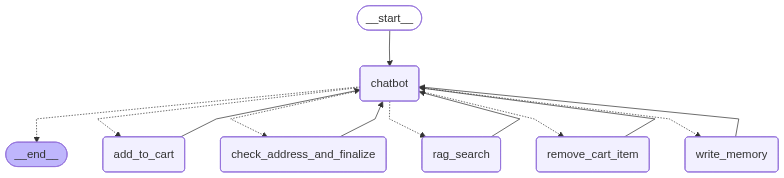

In [ ]:
import uuid
from typing import List, Optional, Literal, Dict, Any
import asyncio
import pandas as pd
import httpx
import os
import json
import hashlib
import time
import logging
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_postgres import PGVector
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, CSVLoader
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, merge_message_runs
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import interrupt

from langchain_community.document_loaders import CSVLoader, WebBaseLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_postgres import PGVector
from langchain_huggingface import HuggingFaceEmbeddings
import time
import random
import logging
from typing import Any, Callable, Tuple
from functools import wraps
from openai import OpenAI, APIError, RateLimitError, Timeout
from threading import Lock

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from trustcall import create_extractor
from langchain_groq import ChatGroq

from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("API_KEY")

if not API_KEY:
    raise ValueError("API_KEY not found in environment variables. Please check your .env file")

import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

try:
    model = ChatGroq(model="llama-3.3-70b-versatile", api_key=API_KEY)
except Exception as e:
    raise ValueError(f"Failed to initialize ChatGroq model. Check your API key: {e}")


def retry_with_backoff(
        max_retries: int = 5,
        initial_delay: float = 1.0,
        exponential_base: float = 2.0,
        jitter: str = "full",
        exceptions: Tuple = (Exception,)
):
    """
    Retry decorator with exponential backoff and optional jitter.

    Jitter modes:
        - none: no jitter
        - full: random(0, delay)
        - equal: delay/2 + random(0, delay/2)
        - decorrelated: random(initial_delay, delay * 3)
    """

    def add_jitter(delay: float) -> float:
        if jitter == "none":
            return delay
        if jitter == "full":
            return random.uniform(0, delay)
        if jitter == "equal":
            return delay / 2 + random.uniform(0, delay / 2)
        if jitter == "decorrelated":
            return random.uniform(initial_delay, delay * 3)
        return delay

    def decorator(func: Callable) -> Callable:
        @wraps(func)
        def wrapper(*args, **kwargs) -> Any:
            delay = initial_delay
            last_exception = None

            for attempt in range(1, max_retries + 2):
                try:
                    return func(*args, **kwargs)

                except exceptions as e:
                    last_exception = e

                    if attempt > max_retries:
                        logger.error(f"Failed after {max_retries} attempts: {e}")
                        raise

                    sleep_time = add_jitter(delay)
                    logger.warning(
                        f"Attempt {attempt} failed: {e}. "
                        f"Retrying in {sleep_time:.2f}s"
                    )

                    time.sleep(sleep_time)
                    delay *= exponential_base

            raise last_exception

        return wrapper

    return decorator




MSG_PROMPT= """
You are a whatsapp assistant, your duty is to assist business owners attend to customers.

Your primary responsibilities:
- Provide excellent customer service with a warm, conversational tone
- Help customers find information about menu items, pricing, and availability
- Remember customer preferences and delivery addresses for personalized service
- Guide customers through the complete order process including address collection
- Handle common questions efficiently while knowing when to escalate complex issues
- Add items to cart and always ask customer if they want to add to their order.
- When customers are ready to pay or complete their order, check for their address and confirm if they want pick-up or delivery.
- If user wants delivery, go through prior conversations to check for address, if no address provided during conversation, ask user for delivery address 

Customer Profile:
<user_profile>
{user_profile}
</user_profile>
"""

TRUSTCALL_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, address, location, cart)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
   - Delivery address
   - Ordered items
3. Merge any new information with existing memory
4. Format the memory as a clear, structured profile
5. If new information conflicts with existing memory, keep the most recent version

CRITICAL: 
- Use null (not the string "None") for fields with no information
- Only include factual information directly stated by the user
- Do not make assumptions or inferences
- Leave fields as null if not mentioned in the conversation

Based on the chat history below, please update the user information:"""

class Profile(BaseModel):
    """User profile information for personalizing customer service.
    
    IMPORTANT: Use null for unknown fields, not the string "None".
    Only populate fields with actual information from the conversation.
    """
    
    name: Optional[str] = Field(
        default=None, 
        description="Customer's name. Use null if not mentioned."
    )
    location: Optional[str] = Field(
        default=None, 
        description="Customer's general location or city. Use null if not mentioned."
    )
    address: Optional[str] = Field(
        default=None, 
        description="Customer's full delivery address. Use null if not mentioned."
    )
    cart: Optional[List[str]] = Field(
        default=None, 
        description="List of items in customer's order. Use null if no items ordered yet."
    )
    
    human_active: Optional[bool] = Field(
        default=None, 
        description="Whether a human agent is currently handling this customer. Use null if unknown."
    )

# -----------------------------
# Profile extractor
# -----------------------------
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

from typing import List, Union, Optional

# Update memory tool
from typing import List, Union, Optional
from pydantic import BaseModel, Field

class CartItem(BaseModel):
    """Cart item with quantity support"""
    item: str = Field(description="Name of the product/item")
    quantity: int = Field(
        default=1, 
        ge=1, 
        le=99, 
        description="Quantity to add (1-99, default: 1)"
    )


class CustomerAction(BaseModel):
    """Handle customer requests which may include multiple actions.
    
    This tool should be called whenever the customer:
    - Shares personal information (name, address, preferences)
    - Asks about menu items or availability
    - Wants to add/remove items from cart
    - Wants to place an order
    """
    
    update_profile: bool = Field(
        default=False,
        description="True if message contains profile information to save (name, location, address, preferences) - NOT for cart items"
    )
    
    search_menu: bool = Field(
        default=False,
        description="True if customer is asking about menu items, prices, or availability without wanting to order yet"
    )
    
    search_query: Optional[str] = Field(
        default=None,
        description="The specific menu item, category, or question they're asking about"
    )
    
    add_to_cart: bool = Field(
        default=False,
        description="True if customer wants to add item(s) to their cart or order something"
    )
    
    # ✅ FIX: Use List[CartItem] instead of Union
    cart_items: Optional[List[CartItem]] = Field(
        default=None,
        description=(
            "List of items to add to cart with quantities. "
            "Each item should have 'item' (name) and 'quantity' (number). "
            "Example: [{'item': 'Burger', 'quantity': 2}, {'item': 'Fries', 'quantity': 1}]"
        )
    )
    
    remove_from_cart: bool = Field(
        default=False,
        description="True if customer wants to remove item(s) from cart"
    )
    
    # Use List[CartItem] instead of Union
    items_to_remove: Optional[List[CartItem]] = Field(
        default=None,
        description=(
            "Items to remove from cart with quantities. "
            "Each item should have 'item' (name) and 'quantity' (number to remove). "
            "Example: [{'item': 'Burger', 'quantity': 1}]"
        )
    )
    
    view_cart: bool = Field(
        default=False,
        description="True if customer wants to see what's in their cart"
    )
    
    ready_to_order: bool = Field(
        default=False,
        description="True if customer is ready to place/finalize their order"
    )

    ready_to_pay: bool = Field(
        default=False,
        description="True if customer is ready to pay for their order"
    )


logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


MAX_MEMORY_MESSAGES = 100
EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
from psycopg_pool import AsyncConnectionPool
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.store.postgres.aio import AsyncPostgresStore
from dotenv import load_dotenv
import os
import logging

load_dotenv()
logger = logging.getLogger(__name__)

# Use DIRECT connection for LangGraph (checkpointer/store)
POSTGRES_URI = os.getenv("POSTGRES_URI")
# Use POOLER connection for PGVector
POSTGRES_URI_POOLER = os.getenv("POSTGRES_URI_POOLER")

if not POSTGRES_URI:
    raise ValueError("POSTGRES_URI not set")
if not POSTGRES_URI_POOLER:
    raise ValueError("POSTGRES_URI_POOLER not set")


# After all imports and before any functions
store = None
saver = None

# Make sure this is BEFORE the setup_database function
# -----------------------------
# Connect to DB
# -----------------------------

_pool: AsyncConnectionPool = None

async def drop_old_tables_once():
    """Drop old tables - run once then comment out"""
    import asyncpg
    
    print("Dropping old tables...")
    clean_uri = POSTGRES_URI.split('?')[0]
    conn = await asyncpg.connect(clean_uri, timeout=30)
    
    try:
        await conn.execute("DROP TABLE IF EXISTS store CASCADE;")
        await conn.execute("DROP TABLE IF EXISTS checkpoints CASCADE;")
        await conn.execute("DROP TABLE IF EXISTS writes CASCADE;")
        print("✅ Old tables dropped")
    finally:
        await conn.close()

async def create_tables_manually():
    """Create tables using the connection pool instead of direct connection"""
    print("Creating tables manually via connection pool...")
    
    pool = await get_pool()
    
    async with pool.connection() as conn:
        # Create store table
        await conn.execute("""
            CREATE TABLE IF NOT EXISTS store (
                prefix TEXT NOT NULL,
                key TEXT NOT NULL,
                value JSONB NOT NULL,
                created_at TIMESTAMP WITH TIME ZONE DEFAULT CURRENT_TIMESTAMP,
                updated_at TIMESTAMP WITH TIME ZONE DEFAULT CURRENT_TIMESTAMP,
                ttl_minutes INTEGER,
                expires_at TIMESTAMP WITH TIME ZONE,
                PRIMARY KEY (prefix, key)
            );
        """)
        
        # Create indexes
        await conn.execute("CREATE INDEX IF NOT EXISTS store_prefix_key_idx ON store(prefix, key);")
        await conn.execute("CREATE INDEX IF NOT EXISTS store_prefix_idx ON store(prefix);")
        await conn.execute("CREATE INDEX IF NOT EXISTS store_expires_at_idx ON store(expires_at) WHERE expires_at IS NOT NULL;")
        print("✅ Store table created")
        
        # Create checkpoints table
        await conn.execute("""
            CREATE TABLE IF NOT EXISTS checkpoints (
                thread_id TEXT NOT NULL,
                checkpoint_ns TEXT NOT NULL DEFAULT '',
                checkpoint_id TEXT NOT NULL,
                parent_checkpoint_id TEXT,
                type TEXT,
                checkpoint JSONB NOT NULL,
                metadata JSONB NOT NULL DEFAULT '{}',
                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id)
            );
        """)
        
        await conn.execute("""
            CREATE INDEX IF NOT EXISTS checkpoints_thread_id_checkpoint_ns_idx 
            ON checkpoints(thread_id, checkpoint_ns);
        """)
        print("✅ Checkpoints table created")
        
        # Create writes table
        await conn.execute("""
            CREATE TABLE IF NOT EXISTS writes (
                thread_id TEXT NOT NULL,
                checkpoint_ns TEXT NOT NULL DEFAULT '',
                checkpoint_id TEXT NOT NULL,
                task_id TEXT NOT NULL,
                idx INTEGER NOT NULL,
                channel TEXT NOT NULL,
                type TEXT,
                value JSONB,
                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id, task_id, idx)
            );
        """)
        
        await conn.execute("""
            CREATE INDEX IF NOT EXISTS writes_thread_id_checkpoint_ns_checkpoint_id_idx 
            ON writes(thread_id, checkpoint_ns, checkpoint_id);
        """)
        print("Writes table created")

async def get_pool() -> AsyncConnectionPool:
    global _pool
    if _pool is None:
        _pool = AsyncConnectionPool(
            conninfo=POSTGRES_URI,
            min_size=1,
            max_size=10,
            open=False,
            timeout=120,
            max_waiting=5,
            max_lifetime=1800,
            max_idle=300,
        )
        await _pool.open()
        async with _pool.connection() as conn:
            await conn.execute("SELECT 1")
        print("✅ Database pool connected successfully")
    return _pool


async def setup_database():
    global store, saver
    print("=== SETUP_DATABASE CALLED ===")
    
    # Drop old tables (UNCOMMENT for first run only, then comment out)
    # await drop_old_tables_once()
    
    # Try manual table creation first (more reliable with Supabase pooler)
    await create_tables_manually()
    
    pool = await get_pool()
    
    # NEW: Create custom user_profiles table with PROPER array syntax
    async with pool.connection() as conn:
        print("Creating custom user_profiles table...")
        
        # Drop the table first to recreate with correct schema
        await conn.execute("DROP TABLE IF EXISTS user_profiles CASCADE")
        
        # Create with TEXT[] array type (proper PostgreSQL syntax)
        await conn.execute("""
            CREATE TABLE user_profiles (
                business_id VARCHAR(255) NOT NULL,  
                user_id VARCHAR(255) NOT NULL, 
                name VARCHAR(255),
                cart JSONB,
                address TEXT,
                location VARCHAR(255),
                human_active BOOLEAN DEFAULT FALSE,
                created_at TIMESTAMP DEFAULT NOW(),
                updated_at TIMESTAMP DEFAULT NOW(),
                PRIMARY KEY (business_id, user_id)  
            )
        """)
        
        await conn.execute("""
            CREATE INDEX IF NOT EXISTS idx_user_profiles_user_id ON user_profiles(user_id)
        """)
        
        await conn.execute("""
            CREATE INDEX IF NOT EXISTS idx_user_profiles_business_id ON user_profiles(business_id)
        """)
        
        print("✅ Custom user_profiles table created with array column!")
    
    # Verify tables exist
    async with pool.connection() as conn:
        print("Verifying tables...")
        
        # Check store table
        store_result = await conn.execute(
            "SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'store')"
        )
        store_exists = (await store_result.fetchone())[0]
        
        # Check checkpoints table
        checkpoints_result = await conn.execute(
            "SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'checkpoints')"
        )
        checkpoints_exists = (await checkpoints_result.fetchone())[0]
        
        
        # Check writes table
        writes_result = await conn.execute(
            "SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'writes')"
        )
        writes_exists = (await writes_result.fetchone())[0]
        
        # Check user_profiles table
        profiles_result = await conn.execute(
            "SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'user_profiles')"
        )
        user_profiles_exists = (await profiles_result.fetchone())[0]
        
        print(f"✅ Store table exists: {store_exists}")
        print(f"✅ Checkpoints table exists: {checkpoints_exists}")
        print(f"✅ Writes table exists: {writes_exists}")
        print(f"✅ User profiles table exists: {user_profiles_exists}")
        
        if not (store_exists and checkpoints_exists and writes_exists and user_profiles_exists):
            raise Exception("Tables were not created properly!")
        
        # Verify cart column exists and is array type
        column_check = await conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name = 'user_profiles' AND column_name = 'cart'
        """)
        cart_col = await column_check.fetchone()
        if cart_col:
            print(f"✅ Cart column: {cart_col[0]} ({cart_col[1]})")
        else:
            raise Exception("Cart column was not created!")
    
    # Create store and saver instances
    print("Creating store and saver instances...")
    store = AsyncPostgresStore(pool)
    saver = AsyncPostgresSaver(pool)
    print("✅ Database ready!")
    
    return store, saver

    
saver
store


async def chatbot(state: MessagesState, config: RunnableConfig):
    """Load memory from the store and use it to personalize the chatbot's response."""
    global store
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    business_id = config["configurable"]["business_id"]

    # Consistent namespace order
    namespace = ("profile", business_id, user_id)
    key = "user_memory"
    existing_memory = await store.aget(namespace, key)


    # Extract the actual memory content if it exists
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MSG_PROMPT.format(user_profile=existing_memory_content)
    
    # FIXED: Pass both system message AND conversation history
    response = await model.bind_tools([CustomerAction]).ainvoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )
    
    return {"messages": [response]}




async def write_memory(state: MessagesState, config: RunnableConfig):
    """Extract and save profile information."""
    global store
    user_id = config["configurable"]["user_id"]
    business_id = config["configurable"]["business_id"]
    
    namespace = ("profile", business_id, user_id)
    
    existing_items = await store.asearch(namespace)
    tool_name = "Profile"
    existing_memories = (
        [(item.key, tool_name, item.value) for item in existing_items]
        if existing_items else None
    )
    
    conversation_history = [
        msg for msg in state["messages"]
        if not (hasattr(msg, 'type') and msg.type == 'tool')
    ]
    
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(memory=existing_memories)
    updated_messages = list(merge_message_runs(
        [SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + conversation_history
    ))
    
    result = await profile_extractor.ainvoke({
        "messages": updated_messages,
        "existing": existing_memories
    })
    
    profile_data: Profile = result['responses'][0]
    
    print("=" * 50)
    print("DEBUG: Extracted profile data:")
    print(f"Business ID: {business_id}")
    print(f"User ID: {user_id}")
    print(f"Name: {profile_data.name}")
    print(f"Location: {profile_data.location}")
    print(f"Address: {profile_data.address}")
    print(f"Cart: {profile_data.cart}")
    print(f"Human Active: {profile_data.human_active}")
    print("=" * 50)
    
    # Save to LangGraph store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        await store.aput(
            namespace,
            "user_memory",
            r.model_dump(mode="json"),
        )
    
    # Convert cart to JSON string before inserting
    pool = await get_pool()
    async with pool.connection() as conn:
        # Convert cart to JSON - handle both list and dict formats
        cart_json = json.dumps(profile_data.cart) if profile_data.cart is not None else None
        
        await conn.execute(
            '''
            INSERT INTO user_profiles (business_id, user_id, name, cart, address, location, human_active, updated_at)
            VALUES (%s, %s, %s, %s, %s, %s, %s, NOW())
            ON CONFLICT (business_id, user_id) DO UPDATE SET
                name = COALESCE(EXCLUDED.name, user_profiles.name),
                cart = COALESCE(EXCLUDED.cart, user_profiles.cart),
                address = COALESCE(EXCLUDED.address, user_profiles.address),
                location = COALESCE(EXCLUDED.location, user_profiles.location),
                human_active = COALESCE(EXCLUDED.human_active, user_profiles.human_active),
                updated_at = NOW()
            ''',
            (
                business_id,
                user_id, 
                profile_data.name, 
                cart_json,  # ✅ Now it's a JSON string
                profile_data.address,
                profile_data.location,
                profile_data.human_active
            )
        )
    
    # Return tool message
    tool_calls = state['messages'][-1].tool_calls
    return {
        "messages": [{
            "role": "tool",
            "content": "Profile information saved successfully",
            "tool_call_id": tool_calls[0]['id']
        }]
    }


async def check_address_and_finalize(state: MessagesState, config: RunnableConfig):
    """Check if user has address, ask if not, or prepare for escalation."""
    global store
    user_id = config["configurable"]["user_id"]
    business_id = config["configurable"]["business_id"]
    
    # FIXED: Consistent namespace
    namespace = ("profile", business_id, user_id)
    
    existing_memory = await store.aget(namespace, "user_memory")
    
    # Check for address in profile
    has_address = False
    if existing_memory:
        profile_data = existing_memory.value
        has_address = profile_data.get('address') is not None
    
    if not has_address:
        # Ask for address
        tool_calls = state['messages'][-1].tool_calls
        return {
            "messages": [{
                "role": "tool",
                "content": "User is ready to order but no delivery address on file. Please ask for their delivery address.",
                "tool_call_id": tool_calls[0]['id']
            }]
        }
    else:
        # Has address - ready to escalate
        tool_calls = state['messages'][-1].tool_calls
        return {
            "messages": [{
                "role": "tool",
                "content": "User has address on file and is ready to complete order. Escalating to operator.",
                "tool_call_id": tool_calls[0]['id']
            }]
        }
    
    
async def add_to_cart(state: MessagesState, config: RunnableConfig):
    """Add items to the user's cart with quantity support."""
    global store
    user_id = config["configurable"]["user_id"]
    business_id = config["configurable"]["business_id"]
    
    # Configuration
    MAX_CART_SIZE = 50
    MAX_ITEM_QUANTITY = 99
    
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    args = tool_call.get('args', {})
    
    cart_items = args.get('cart_items', [])
    
    if not isinstance(cart_items, list):
        return {
            "messages": [{
                "role": "tool",
                "content": "Invalid cart items format. Expected a list.",
                "tool_call_id": tool_call['id']
            }]
        }
    
    if not cart_items:
        return {
            "messages": [{
                "role": "tool",
                "content": "No items specified to add to cart.",
                "tool_call_id": tool_call['id']
            }]
        }
    
    try:
        pool = await get_pool()
        
        async with pool.connection() as conn:
            # Get current cart
            result = await conn.execute(
                "SELECT cart FROM user_profiles WHERE business_id = %s AND user_id = %s",
                (business_id, user_id)
            )
            
            row = await result.fetchone()
            
            # Parse cart from JSON if it exists
            if row and row[0]:
                import json
                current_cart = json.loads(row[0]) if isinstance(row[0], str) else row[0]
            else:
                current_cart = {}
            
            # Convert old list format to dict format if needed
            if isinstance(current_cart, list):
                current_cart = {item: 1 for item in current_cart}
            
            # Process new items
            added_items = []
            updated_items = []
            quantity_limited_items = []
            
            for item in cart_items:
                # Now we only expect dict format
                if isinstance(item, dict):
                    item_name = item.get('item')
                    quantity = item.get('quantity', 1)
                else:
                    # Fallback for safety
                    continue
                
                if not item_name:
                    continue
                
                # Calculate new quantity
                current_qty = current_cart.get(item_name, 0)
                new_qty = current_qty + quantity
                
                # Apply quantity limit
                if new_qty > MAX_ITEM_QUANTITY:
                    new_qty = MAX_ITEM_QUANTITY
                    quantity_limited_items.append(item_name)
                
                # Update cart
                if current_qty == 0:
                    added_items.append(f"{item_name} (x{new_qty})")
                else:
                    updated_items.append(f"{item_name} ({current_qty} → {new_qty})")
                
                current_cart[item_name] = new_qty
            
            # Check unique items limit
            if len(current_cart) > MAX_CART_SIZE:
                return {
                    "messages": [{
                        "role": "tool",
                        "content": f"Cannot add items. Cart limit is {MAX_CART_SIZE} unique items.",
                        "tool_call_id": tool_call['id']
                    }]
                }
            
            # Calculate total items
            total_items = sum(current_cart.values())
            
            # Convert to JSON before inserting
            import json
            cart_json = json.dumps(current_cart)
            
            # Update database
            await conn.execute(
                '''
                INSERT INTO user_profiles (business_id, user_id, cart, updated_at)
                VALUES (%s, %s, %s, NOW())
                ON CONFLICT (business_id, user_id) DO UPDATE SET
                    cart = EXCLUDED.cart,
                    updated_at = NOW()
                ''',
                (business_id, user_id, cart_json)
            )
            
            # Update store
            try:
                namespace = ("profile", business_id, user_id)
                existing_memory = await store.aget(namespace, "user_memory")
                
                if existing_memory:
                    memory_data = existing_memory.value
                    memory_data['cart'] = current_cart
                else:
                    memory_data = {'cart': current_cart}
                
                await store.aput(namespace, "user_memory", memory_data)
            except Exception as store_error:
                logger.warning(f"Failed to update store: {store_error}")
        
        # Format success message
        message_parts = []
        
        if added_items:
            message_parts.append(f"Added: {', '.join(added_items)}")
        
        if updated_items:
            message_parts.append(f"Updated: {', '.join(updated_items)}")
        
        message = ". ".join(message_parts) if message_parts else "Cart updated"
        message += f". Cart now has {len(current_cart)} unique item(s) ({total_items} total items)."
        
        if quantity_limited_items:
            message += f" Note: {', '.join(quantity_limited_items)} reached maximum quantity of {MAX_ITEM_QUANTITY}."
        
        return {
            "messages": [{
                "role": "tool",
                "content": message,
                "tool_call_id": tool_call['id']
            }]
        }
    
    except Exception as e:
        logger.error(f"Failed to add to cart: {e}")
        return {
            "messages": [{
                "role": "tool",
                "content": "Failed to add items to cart. Please try again.",
                "tool_call_id": tool_call['id']
            }]
        }


async def remove_cart_item(state: MessagesState, config: RunnableConfig):
    """Remove items from the user's cart with quantity support."""
    global store

    user_id = config["configurable"]["user_id"]
    business_id = config["configurable"]["business_id"]

    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    args = tool_call.get("args", {})

    items_to_remove = args.get("items_to_remove", [])

    
    if not isinstance(items_to_remove, list):
        return {
            "messages": [{
                "role": "tool",
                "content": "Invalid items format. Expected a list.",
                "tool_call_id": tool_call["id"]
            }]
        }

    if not items_to_remove:
        return {
            "messages": [{
                "role": "tool",
                "content": "No items specified to remove from cart.",
                "tool_call_id": tool_call["id"]
            }]
        }

    try:
        pool = await get_pool()

        async with pool.connection() as conn:
            # ---- Load cart ----
            result = await conn.execute(
                "SELECT cart FROM user_profiles WHERE business_id = %s AND user_id = %s",
                (business_id, user_id)
            )
            row = await result.fetchone()

            raw_cart = row[0] if row else None

            # Normalize cart format → always a dict
            if isinstance(raw_cart, str):
                current_cart = json.loads(raw_cart)
            elif isinstance(raw_cart, list):
                current_cart = {item: 1 for item in raw_cart}
            else:
                current_cart = raw_cart or {}

            if not current_cart:
                return {
                    "messages": [{
                        "role": "tool",
                        "content": "Your cart is empty. Nothing to remove.",
                        "tool_call_id": tool_call["id"]
                    }]
                }

            removed_items = []
            updated_items = []
            not_found_items = []

            # ---- Process removals ----
            for item in items_to_remove:
                if not isinstance(item, dict):
                    continue

                item_name = item.get("item")
                quantity_to_remove = item.get("quantity", 1)

                if not item_name:
                    continue

                if item_name not in current_cart:
                    not_found_items.append(item_name)
                    continue

                current_qty = current_cart[item_name]

                if quantity_to_remove >= current_qty:
                    removed_items.append(f"{item_name} (all {current_qty} removed)")
                    del current_cart[item_name]
                else:
                    new_qty = current_qty - quantity_to_remove
                    current_cart[item_name] = new_qty
                    updated_items.append(f"{item_name} ({current_qty} → {new_qty})")

            # ---- No changes? ----
            if not removed_items and not updated_items:
                available_items = [f"{item} (x{qty})" for item, qty in current_cart.items()]
                return {
                    "messages": [{
                        "role": "tool",
                        "content": (
                            f"Could not find items to remove: {', '.join(not_found_items)}. "
                            f"Your cart contains: {', '.join(available_items)}."
                        ),
                        "tool_call_id": tool_call["id"]
                    }]
                }

            # ---- Save updated cart ----
            await conn.execute(
                """
                UPDATE user_profiles
                SET cart = %s, updated_at = NOW()
                WHERE business_id = %s AND user_id = %s
                """,
                (json.dumps(current_cart), business_id, user_id)
            )

            # ---- Update memory store (optional) ----
            try:
                namespace = ("profile", business_id, user_id)
                existing_memory = await store.aget(namespace, "user_memory")
                memory_data = existing_memory.value if existing_memory else {}
                memory_data["cart"] = current_cart
                await store.aput(namespace, "user_memory", memory_data)
            except Exception as store_error:
                logger.warning(f"Failed to update store, but database was updated: {store_error}")

        # ---- Build success message ----
        parts = []
        if removed_items:
            parts.append(f"Removed completely: {', '.join(removed_items)}")
        if updated_items:
            parts.append(f"Reduced quantity: {', '.join(updated_items)}")

        message = ". ".join(parts) if parts else "Cart updated"

        if current_cart:
            remaining_items = [f"{item} (x{qty})" for item, qty in current_cart.items()]
            total_remaining = sum(current_cart.values())
            message += (
                f". Cart now has {len(current_cart)} unique item(s) ({total_remaining} total): "
                f"{', '.join(remaining_items)}."
            )
        else:
            message += ". Your cart is now empty."

        if not_found_items:
            message += f" Note: Could not find: {', '.join(not_found_items)}."

        return {
            "messages": [{
                "role": "tool",
                "content": message,
                "tool_call_id": tool_call["id"]
            }]
        }

    except Exception as e:
        logger.error(f"Failed to remove from cart: {e}")
        return {
            "messages": [{
                "role": "tool",
                "content": "Failed to remove items from cart. Please try again.",
                "tool_call_id": tool_call["id"]
            }]
        }



## RAG

# Setup logging
logger = logging.getLogger(__name__)

# Configuration
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# KB1 Setup
KB1_DOC_PATH = r"C:\Users\HP\Desktop\WAHA\synthetic_restaurant_menu_10000.csv"

# 
_vector_store_cache = {}
_retriever_cache = {}
_file_hash_cache = {}
_embeddings_cache = None  
_documents_loaded = {} 


async def get_file_hash(path):
    """Compute a hash of the file contents to detect changes."""
    hasher = hashlib.sha256()
    loop = asyncio.get_event_loop()
    
    def _read_file():
        with open(path, "rb") as f:
            return hasher.update(f.read())
    
    await loop.run_in_executor(None, _read_file)
    return hasher.hexdigest()

@retry_with_backoff(
    max_retries=3,
    initial_delay=1.0,
    jitter="full",
    exceptions=(APIError, RateLimitError, Timeout)
)
async def initialize_rag(business_id=None, doc_path=None):
    """Initialize RAG system with Supabase pgvector. Call once at startup per business."""
    global _vector_store_cache, _retriever_cache, _file_hash_cache, _embeddings_cache, _documents_loaded
    
    # CRITICAL: Validate business_id
    if not business_id:
        raise ValueError("business_id is required for RAG initialization")
    
    # FIXED: Check if already initialized for THIS business
    if business_id in _retriever_cache and _documents_loaded.get(business_id, False):
        print(f"RAG already initialized for business {business_id}")
        return _retriever_cache[business_id]
    
    document_path = doc_path or KB1_DOC_PATH

    try:
        # Initialize embeddings once and store in global cache (shared across businesses)
        if _embeddings_cache is None:
            print("Initializing embeddings model...")
            _embeddings_cache = HuggingFaceEmbeddings(
                model_name=EMBEDDING_MODEL_NAME,
                model_kwargs={'device': 'cpu'}
            )
        
        loop = asyncio.get_event_loop()
        
        # ✅ FIXED: Use business_id in collection name
        collection_name = f"business_{business_id}_menu"
        print(f"Connecting to Supabase pgvector for collection: {collection_name}")
        
        # Initialize PGVector connection to Supabase (use pooler)
        vector_store = PGVector(
            embeddings=_embeddings_cache,
            collection_name=collection_name,
            connection=POSTGRES_URI_POOLER,  # Use pooler for PGVector
            use_jsonb=True,
        )
        
        # Check if documents already exist in the collection
        try:
            print(f"Checking for existing documents in {collection_name}...")
            # Try a simple search to see if collection has data
            test_results = await loop.run_in_executor(
                None,
                lambda: vector_store.similarity_search("test", k=1)
            )
            
            if test_results and len(test_results) > 0:
                # Check if file has changed
                current_hash = await get_file_hash(document_path)
                
                print(f"✅ Found existing documents in Supabase for business {business_id}")
                _file_hash_cache[business_id] = current_hash
                _documents_loaded[business_id] = True
                _vector_store_cache[business_id] = vector_store
                _retriever_cache[business_id] = vector_store.as_retriever(search_kwargs={"k": 5})
                return _retriever_cache[business_id]
                
        except Exception as e:
            print(f"No existing documents found for business {business_id}: {e}")
            print("Will load documents from file...")
        
        # Load and process documents
        print(f"Building knowledge base from file for business {business_id}...")
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_documents = []
        
        # Load from document
        if document_path and os.path.exists(document_path):
            print(f"Processing {document_path}")
            if document_path.lower().endswith(".pdf"):
                loader = PyPDFLoader(document_path)
            elif document_path.lower().endswith(".docx"):
                loader = Docx2txtLoader(document_path)
            elif document_path.lower().endswith(".csv"):
                loader = CSVLoader(file_path=document_path, encoding="utf-8-sig")
            else:
                raise ValueError(f"Unsupported file format: {document_path}")
            
            docs = await loop.run_in_executor(None, loader.load)
            doc_chunks = await loop.run_in_executor(None, splitter.split_documents, docs)
            all_documents.extend(doc_chunks)
            print(f"Loaded {len(doc_chunks)} chunks from {document_path}")

        if not all_documents:
            raise ValueError("No documents were loaded")

        # Store file hash per business
        _file_hash_cache[business_id] = await get_file_hash(document_path)
        
        print(f"Adding {len(all_documents)} document chunks to Supabase for business {business_id}...")
        print("⏳ This may take a few minutes for large datasets...")
        
        # Add documents to PGVector in batches for better performance
        batch_size = 100
        for i in range(0, len(all_documents), batch_size):
            batch = all_documents[i:i+batch_size]
            await loop.run_in_executor(
                None,
                lambda b=batch: vector_store.add_documents(b)
            )
            print(f"  Progress: {min(i+batch_size, len(all_documents))}/{len(all_documents)} documents added")
        
        _documents_loaded[business_id] = True
        _vector_store_cache[business_id] = vector_store
        _retriever_cache[business_id] = vector_store.as_retriever(search_kwargs={"k": 5})
        print(f"✅ Setup complete - {len(all_documents)} documents indexed in Supabase for business {business_id}!")
        
        return _retriever_cache[business_id]
      
    except Exception as e:
        logger.error(f"RAG initialization failed for business {business_id}: {e}")
        raise



async def refresh_rag(business_id=None, doc_path=None):
    """Refresh RAG when file changes detected - clears and reloads documents for a specific business."""
    global _vector_store_cache, _retriever_cache, _file_hash_cache, _embeddings_cache, _documents_loaded
    
    if not business_id:
        raise ValueError("business_id is required for RAG refresh")
    
    print(f"🔄 Refreshing knowledge base for business {business_id}...")
    
    loop = asyncio.get_event_loop()
    
    # Delete existing collection in Supabase for this business
    if business_id in _vector_store_cache:
        try:
            print(f"Clearing existing documents from Supabase for business {business_id}...")
            await loop.run_in_executor(
                None,
                lambda: _vector_store_cache[business_id].delete_collection()
            )
            print("✅ Collection cleared")
        except Exception as e:
            print(f"Error clearing collection: {e}")
    
    # Clear cache for this business only
    _vector_store_cache.pop(business_id, None)
    _retriever_cache.pop(business_id, None)
    _file_hash_cache.pop(business_id, None)
    _documents_loaded.pop(business_id, None)
    # Keep embeddings cache to avoid reloading model
    
    # Reinitialize for this business
    retriever = await initialize_rag(business_id=business_id, doc_path=doc_path)
    print(f"✅ Knowledge base refreshed for business {business_id}!")
    
    return retriever


# File change handler
class KBUpdateHandler(FileSystemEventHandler):
    def __init__(self, business_id):
        self.business_id = business_id
        super().__init__()
    
    def on_modified(self, event):
        if event.src_path == os.path.abspath(KB1_DOC_PATH):
            print(f"📁 Detected change in file: {event.src_path} for business {self.business_id}")
            try:
                asyncio.create_task(refresh_rag(business_id=self.business_id))
            except Exception as e:
                logger.error(f"Error refreshing: {e}")


def start_file_monitoring(business_id):
    """Start watching file for changes for a specific business."""
    event_handler = KBUpdateHandler(business_id)
    observer = Observer()
    
    kb_dir = os.path.dirname(os.path.abspath(KB1_DOC_PATH))
    observer.schedule(event_handler, kb_dir, recursive=False)
    
    observer.start()
    print(f"File monitoring started for business {business_id}...")
    return observer

_init_lock={}
_locks_lock=Lock()

def get_init_lock(business_id):
    """ Get or create lock a particular business ID"""
    with _locks_lock:
        if business_id not in _init_lock:
            _init_lock[business_id]= asyncio.Lock()
        return _init_lock[business_id]
        
@retry_with_backoff(
    max_retries=3,
    initial_delay=1.0,
    jitter="full",
    exceptions=(ConnectionError, OSError)
)
async def rag_search(state: MessagesState, config: RunnableConfig):
    """Perform RAG search on knowledge base."""
    business_id = config["configurable"]["business_id"]
    
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    args = tool_call.get('args', {})
    search_query = args.get('search_query', '')
    
    if not search_query:
        return {
            "messages": [{
                "role": "tool",
                "content": "No search query provided.",
                "tool_call_id": tool_call['id']
            }]
        }
    
    try:
        # Initialize (has its own retry for APIError, RateLimitError, Timeout)
        init_lock = get_init_lock(business_id)
        async with init_lock:
            if business_id not in _retriever_cache:
                await initialize_rag(business_id=business_id)
        
        retriever = _retriever_cache.get(business_id)
        
        if not retriever:
            return {
                "messages": [{
                    "role": "tool",
                    "content": "Knowledge base not initialized. Please contact support.",
                    "tool_call_id": tool_call['id']
                }]
            }
        
        # This part might benefit from retry (connection issues during search)
        loop = asyncio.get_event_loop()
        relevant_docs = await loop.run_in_executor(
            None, 
            lambda: retriever.invoke(search_query)
        )
        
        if not relevant_docs:
            return {
                "messages": [{
                    "role": "tool",
                    "content": "I couldn't find any information about that in the knowledge base.",
                    "tool_call_id": tool_call['id']
                }]
            }
        
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
        
        return {
            "messages": [{
                "role": "tool",
                "content": context,
                "tool_call_id": tool_call['id']
            }]
        }
    
    except (APIError, RateLimitError, Timeout) as e:
        # These already retried in initialize_rag, don't retry again
        logger.error(f"RAG initialization failed after retries for business {business_id}: {e}")
        return {
            "messages": [{
                "role": "tool",
                "content": "Sorry, knowledge base initialization failed. Please try again later.",
                "tool_call_id": tool_call['id']
            }]
        }
    except Exception as e:
        # Other errors get logged and returned (or let retry wrapper handle if it's ConnectionError/OSError)
        logger.error(f"RAG search failed for business {business_id}: {e}", exc_info=True)
        return {
            "messages": [{
                "role": "tool",
                "content": "Sorry, I encountered an error searching the knowledge base. Please try again.",
                "tool_call_id": tool_call['id']
            }]
        }

def route_customer_action(state: MessagesState) -> str:
    """Route to the appropriate action node based on priority."""
    last_message = state["messages"][-1]
    
    if not (hasattr(last_message, 'tool_calls') and last_message.tool_calls):
        return "__end__"
    
    tool_call = last_message.tool_calls[0]
    args = tool_call.get('args', {})
    
    # Simple priority: Process ONE action at a time
    # Chatbot will handle the rest autonomously
    
    if args.get('ready_to_order'):
        return "check_address_and_finalize"
    
    if args.get('update_profile'):
        return "write_memory"
    
    if args.get('search_menu'):
        return "rag_search"
    
    if args.get('add_to_cart'):
        return "add_to_cart"
    
    if args.get('items_to_remove'):
        return "remove_cart_item"
    
    return "__end__"


# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_node("rag_search", rag_search)
builder.add_node("check_address_and_finalize", check_address_and_finalize)
builder.add_node("add_to_cart", add_to_cart)
builder.add_node("remove_cart_item", remove_cart_item)

builder.add_edge(START, "chatbot")

builder.add_conditional_edges(
    "chatbot",
    route_customer_action,
    {
        "write_memory": "write_memory",
        "rag_search": "rag_search",
        "check_address_and_finalize": "check_address_and_finalize",
        "add_to_cart": "add_to_cart",
        "remove_cart_item": "remove_cart_item",
        "__end__": END
    }
)

# All actions loop back to chatbot
builder.add_edge("write_memory", "chatbot")
builder.add_edge("rag_search", "chatbot")
builder.add_edge("check_address_and_finalize", "chatbot")
builder.add_edge("add_to_cart", "chatbot")
builder.add_edge("remove_cart_item", "chatbot")

store, saver = await setup_database()
graph = builder.compile(checkpointer=saver, store=store)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [5]:
pip install structlog bleach tenacity circuitbreaker


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
business_id= "123ABC"
user_id= "@030"

config = {
    "configurable": {
        "thread_id": f"user_{user_id}_business_{business_id}",
        "user_id": user_id,
        "business_id": business_id
    }
}

print("\n" + "="*60)
print("TEST 1: Setting name and location (NOT full address)")
print("="*60)
input_messages = [HumanMessage(content="My name is Kanny.")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


TEST 1: Setting name and location (NOT full address)
================================ Human Message =================================

My name is Kanny.
================================== Ai Message ==================================
Tool Calls:
  CustomerAction (gwqhp0nwh)
 Call ID: gwqhp0nwh
  Args:
    add_to_cart: False
    cart_items: None
    items_to_remove: None
    ready_to_order: False
    ready_to_pay: False
    remove_from_cart: False
    search_menu: False
    search_query: None
    update_profile: True
    view_cart: False


2025-11-13 20:28:06,217 - ERROR - 1 validation error for Profile
cart
  Input should be a valid list [type=list_type, input_value={'burger': 2, 'sandwich': 3}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type


DEBUG: Extracted profile data:
Business ID: 123ABC
User ID: @030
Name: Kanny
Location: None
Address: 55 Allen Ave, Ikeja, Lagos State, Nigeria
Cart: None
Human Active: None
================================= Tool Message =================================

Profile information saved successfully
================================== Ai Message ==================================

Hello again Kanny, I've updated your name in our system. You already have an order in progress, would you like to proceed with it or make any changes?


In [ ]:
print("\n" + "="*60)
print("TEST 2: Providing FULL delivery address")
print("="*60)
input_messages = [HumanMessage(content="My delivery address is 55 Allen Ave, Ikeja, Lagos State, Nigeria")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
input_messages = [HumanMessage(content="What did I last add to cart?")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [3]:
input_messages = [HumanMessage(content="I need 2 sandwiches and 1 more burger")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need 2 sandwiches and 1 more burger
================================== Ai Message ==================================
Tool Calls:
  CustomerAction (221pzhfxf)
 Call ID: 221pzhfxf
  Args:
    add_to_cart: True
    cart_items: [{'item': 'sandwich', 'quantity': 2}, {'item': 'burger', 'quantity': 1}]
    items_to_remove: None
    ready_to_order: False
    ready_to_pay: False
    remove_from_cart: False
    search_menu: False
    search_query: None
    update_profile: False
    view_cart: False
================================= Tool Message =================================

Added: sandwich (x2), burger (x1). Cart now has 2 unique item(s) (3 total items).
================================== Ai Message ==================================

I've added 2 sandwiches and 1 burger to your cart. You now have a total of 3 items in your cart. Would you like to add anything else to your order or proceed to checkout?


In [ ]:
input_messages = [HumanMessage(content="How many items do I have in my cart?.")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [4]:
input_messages = [HumanMessage(content="remove 1 burger from my cart")]
async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

remove 1 burger from my cart
================================== Ai Message ==================================
Tool Calls:
  CustomerAction (m046fwxje)
 Call ID: m046fwxje
  Args:
    add_to_cart: False
    cart_items: None
    items_to_remove: [{'item': 'burger', 'quantity': 1}]
    ready_to_order: False
    ready_to_pay: False
    remove_from_cart: True
    search_menu: False
    search_query: None
    update_profile: False
    view_cart: False
================================= Tool Message =================================

Removed completely: burger (all 1 removed). Cart now has 1 unique item(s) (2 total): sandwich (x2).
================================== Ai Message ==================================

I've removed 1 burger from your cart. You now have 2 sandwiches left in your cart. Would you like to add anything else to your order or proceed to checkout?


In [ ]:
import time
import random
import logging
from typing import Any, Callable, Tuple
from functools import wraps

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def retry_with_backoff(
        max_retries: int = 5,
        initial_delay: float = 1.0,
        exponential_base: float = 2.0,
        jitter: str = "full",       # "none", "full", "equal", "decorrelated"
        exceptions: Tuple = (Exception,)
):
    """
    Retry decorator with exponential backoff and optional jitter.

    Jitter modes:
        - none: no jitter
        - full: random(0, delay)
        - equal: delay/2 + random(0, delay/2)
        - decorrelated: random(initial_delay, delay * 3)
    """

    def add_jitter(delay: float) -> float:
        if jitter == "none":
            return delay
        if jitter == "full":
            return random.uniform(0, delay)
        if jitter == "equal":
            return delay / 2 + random.uniform(0, delay / 2)
        if jitter == "decorrelated":
            return random.uniform(initial_delay, delay * 3)
        return delay

    def decorator(func: Callable) -> Callable:
        
        @wraps(func)
        def wrapper(*args, **kwargs) -> Any:
            delay = initial_delay
            last_exception = None

            for attempt in range(1, max_retries + 2):
                try:
                    return func(*args, **kwargs)

                except exceptions as e:
                    last_exception = e

                    if attempt > max_retries:
                        logger.error(f"Failed after {max_retries} attempts: {e}")
                        raise

                    sleep_time = add_jitter(delay)
                    logger.warning(
                        f"Attempt {attempt} failed: {e}. "
                        f"Retrying in {sleep_time:.2f}s"
                    )

                    time.sleep(sleep_time)
                    delay *= exponential_base

            raise last_exception

        return wrapper

    return decorator



from openai import OpenAI, APIError, RateLimitError, Timeout

@retry_with_backoff(
    max_retries=3,
    initial_delay=1.0,
    jitter="full",
    exceptions=(APIError, RateLimitError, Timeout)
)

def call_llm_with_retry(prompt: str, model: str = "gpt-4") -> str:
    """Call LLM with automatic retry on transient errors."""
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        timeout=30.0
    )
    return response.choices[0].message.content


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.tools import DuckDuckGoSearchRun

def search_engine(query:str):
    """ This is a simple seacrh engine app"""

    seacrh= DuckDuckGoSearchRun()
    llm = ChatOpenAI(model="GPT-4", temperature=0)

    tools=[
        Tool(
            name="web search",
            func=seacrh.run,
            description="Search the internet for current information. Input should be a search query."
        )
    ]

    